# Standard meta-population model
A lot of this work will compare things against a standard meta-population model. Here it is implemented.

Data is then simulated from the model, and fitted to the model to verify the inference method recovers valid parameters when the underlying data behaves exactly as the model predicts.

This is stage (a) of "Escaping the Rat Race".

## Notebook setup

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from grab_data import get_matrix, get_population_sizes
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from itertools import product
from basic_epidemic import simulate, fit_model, visualise_fits

# Model

### Transition rates
$S \rightarrow I$: $\lambda^{SI}_i(t) = \frac{\beta}{N_i}[\psi I_i(t) + (1-\psi)\sum_{j\ne i} C_{ji} \frac{I_j}{N_j}]$


$I \rightarrow R$: $\lambda^{IR}_i(t) = \gamma$

### Chain binomial
New infections in patch $i$ in $(t, t+\Delta]$:

$\delta_i^{SI}(t) \sim \text{Binomial}(S_i(t), 1-\exp(-\Delta \cdot \lambda^{SI}_i(t)))$

New recoveries in patch $i$ in $(t, t+\Delta]$:

$\delta_i^{IR}(t) \sim \text{Binomial}(I_i(t), 1-\exp(-\Delta \cdot \lambda^{IR}_i(t)))$

### State updates
$S_i(t+\Delta) = S_i(t) - \delta_i^{SI}$

$I_i(t+\Delta) = I_i(t) + \delta_i^{SI} - \delta_i^{IR}$

$R_i(t+\Delta) = R_i(t) + \delta_i^{IR}$




# Log likelihood
I ignore constants, let $S_{it}, I_{it}, R_{it}$ be observations of each state in patch $i$ at time $t$.
We can then write observed versions of the deltas in the model:

$$\hat{\delta}^{SI}_{it} = S_{it} - S_{i(t+\Delta)}$$

$$\hat{\delta}^{IR}_{it} = R_{i(t+\Delta)} - R_{it}$$

Since we have a binomial data generating mechanism for both of these deltas, and plugging in data to the force of infection we get the negative log likelihood:
$$Q(\beta, \gamma, \psi) = \sum_{i,t} -\hat\delta^{IR}_{it}\log(1-e^{-\Delta\cdot\gamma}) + \Delta\cdot\gamma (I_{it} - \hat \delta^{IR}_{it}) - \hat\delta^{SI}_{it}\log(1-e^{-\Delta\cdot\lambda_i(t)}) + \Delta\cdot\lambda_i(t) (I_{it} - \hat \delta^{SI}_{it})$$
we can then maximise this function over our parameters to estimate them.

To avoid optimising over a 3D surface, we split up the likelihood to the $\beta, \psi$ terms and the $\gamma$ terms and optimise separately.





# Simulate using 2011 Census

In [4]:
sim_state = simulate(beta=1.8, gamma=0.3, psi=0.8, flow_matrix=get_matrix(),
                     population_sizes=get_population_sizes(), seed_patch=0, t_delta=0.5)
print(sim_state[1].shape)

(200, 346)


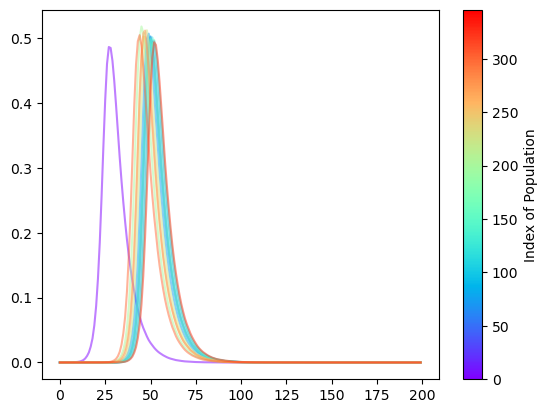

In [5]:
pop_sizes = get_population_sizes()
norm = plt.Normalize(0, pop_sizes.size)
cmap = plt.get_cmap('rainbow')
fig, ax = plt.subplots()

for i in range(0, pop_sizes.size, 25):
    ax.plot(np.arange(sim_state[1].shape[0]), sim_state[1][:, i] / pop_sizes[i], color=cmap(norm(i)), alpha=0.5)
# Add colorbar
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # Required for colorbar
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label("Index of Population")
plt.show()

# Fit model to simulated data

In [6]:
def simulate_and_fit(flow_matrix, population_sizes, seed_patch, t_max=100, t_delta=1):
    true_params = list(product(np.linspace(1, 3, 10), np.linspace(0.2, 0.8, 10), np.array([0.9, 0.8,0.7])))
    results = [[], [], []]
    for b, g, p in true_params:
        if b / g <= 1:
            continue
        sim_data = simulate(beta=b, gamma=g,
                            psi=p, flow_matrix=flow_matrix,
                            population_sizes=population_sizes,
                            seed_patch=seed_patch, t_max=t_max, t_delta=t_delta)
        # not interested in extinctions
        while sim_data[1].sum(axis=(0, 1)) <= 100:
            sim_data = simulate(beta=b, gamma=g,
                                psi=p, flow_matrix=flow_matrix,
                                population_sizes=population_sizes,
                                seed_patch=seed_patch, t_max=t_max, t_delta=t_delta)
        b_hat, g_hat, psi_hat = fit_model(sim_data, flow_matrix, population_sizes, t_delta=t_delta)
        results[0].append(b_hat)
        results[1].append(g_hat)
        results[2].append(psi_hat)

    return np.array(true_params), np.array(results).T

In [ ]:
census_flow = get_matrix()
census_population = get_population_sizes()
true_vals, estimated_vals = simulate_and_fit(flow_matrix=census_flow, population_sizes=census_population, seed_patch=0,
                                             t_max=250, t_delta=0.5)

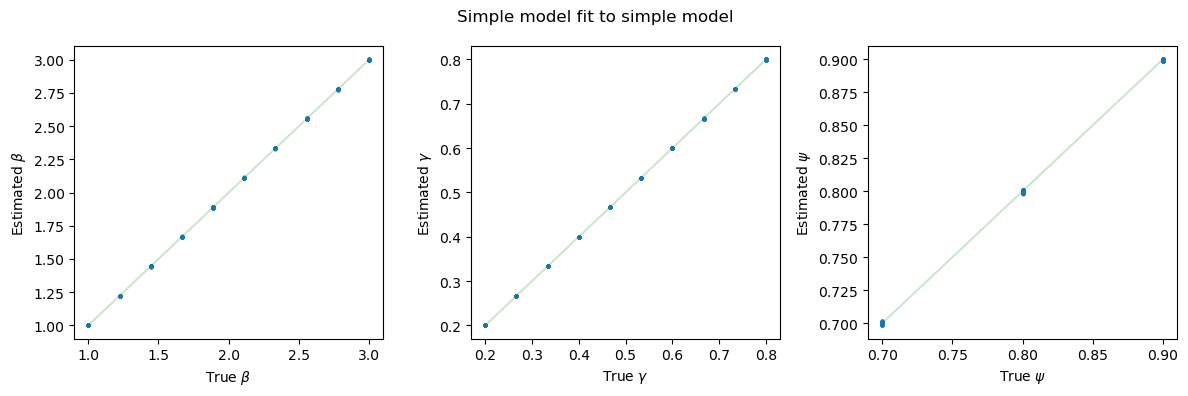

In [11]:
visualise_fits(true_vals, estimated_vals, 'Simple model fit to simple model')

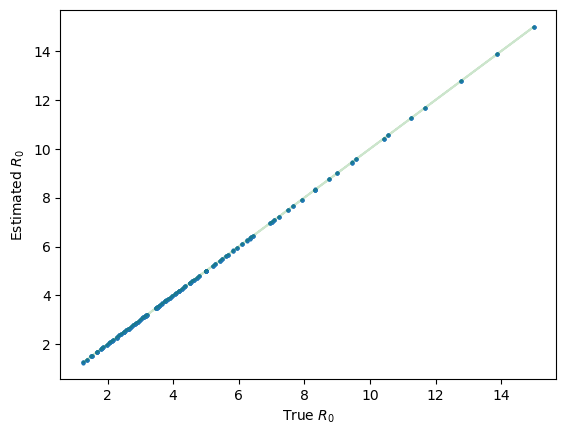

In [9]:
plt.scatter(true_vals[:, 0] / true_vals[:, 1], estimated_vals[:, 0] / estimated_vals[:, 1], s=4)
plt.plot(true_vals[:, 0] / true_vals[:, 1], true_vals[:, 0] / true_vals[:, 1], c='g', alpha=0.2)
plt.xlabel(r'True $R_0$')
plt.ylabel(f'Estimated $R_0$')
plt.show()